In [2]:
using CSV, DataFrames, Distributions,StatsBase, PythonPlot,Random
using AbstractGPs, Stheno

include("processing_functions.jl")

NSF_CAREER_PATH = "/Users/elevien/Dartmouth College Dropbox/Ethan Levien/PROPOSALS/NSFCareer2024/figures/growth_dynamics"

"/Users/elevien/Dartmouth College Dropbox/Ethan Levien/PROPOSALS/NSFCareer2024/figures/growth_dynamics"

I was just using this to explore using stheno, but in the end I used my ``homemade'' Gaussian process code. At one point I would like everything to be done in Julia GP packages. 

In [3]:
df_all = CSV.read("./output/data_processed.csv",DataFrames.DataFrame);
df_all = df_all[df_all.cellcycle .== "i",:]
lineages = unique(df_all.lineage);

function linreg(t,y)
    X = hcat(ones(length(t)),t)
    b = X \y
    return y .- X*b
end

function standardize(x)
    return (x .- mean(x)) ./ std(x)
end

function fit_scale(t,x)
    standardize(linreg(t,x))
end

df_all = combine(groupby(df_all,:lineage),[:time,:lnM_sum]=>fit_scale=>:z,
:age,:age_normed,:time,:lnM,:gr,:gr_dt,:position,:lnM_sum)

Row,lineage,z,age,age_normed,time,lnM,gr,gr_dt,position,lnM_sum
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Float64
1,1,3.1207,0.0,0.0,7.12447,3.83734,0.000501261,-0.000139645,1,3.83734
2,1,3.13919,0.00199809,0.00199809,7.14483,3.84104,0.00048443,-0.00015848,1,3.84104
3,1,3.12151,0.00391374,0.00391374,7.16435,3.8405,0.000508311,-0.000136554,1,3.8405
4,1,3.12412,0.0059079,0.0059079,7.18467,3.84236,0.000491178,-0.000155756,1,3.84236
5,1,3.10606,0.00781962,0.00781962,7.20415,3.84177,0.000527402,-0.000121549,1,3.84177
6,1,3.10092,0.00985598,0.00985598,7.2249,3.84277,0.000504748,-0.000146387,1,3.84277
7,1,3.10258,0.0117893,0.0117893,7.2446,3.84447,0.000518291,-0.000134953,1,3.84447
8,1,3.10609,0.0137589,0.0137589,7.26467,3.84642,0.00050517,-0.00015026,1,3.84642
9,1,3.10985,0.0156638,0.0156638,7.28408,3.84835,0.000524318,-0.000133259,1,3.84835


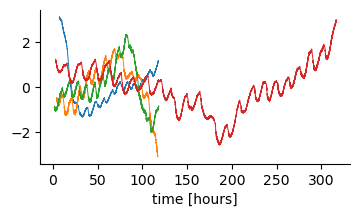

In [4]:
fig,ax = subplots(figsize=(4,2))

for k in 1:length(lineages[1:4])
    df1 = df_all[df_all.lineage .== lineages[k],:]
    ax.plot(df1.time,df1.z,lw=0.7)
    # ax.set_ylim([-6,6]) 
end
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
ax.set_xlabel("time [hours]")

fig

In [6]:
df1 = df_all[df_all.lineage .==lineages[2],:]
inds =collect(range(start =1,stop = length(df1.time),step=40));
#df1= df1[df1.position .== df1.position[4],:]

t = df1.time[inds] ./ df1.time[end]
a = df1.age_normed[inds]
X1 = GPPPInput(:f1,t);
X2 = GPPPInput(:f2,a);
X3 = GPPPInput(:f3,t);
X = BlockData(X1,X2);

f = @gppp let
    f1 = stretch(GP(Matern32Kernel()),10.)
    #f1b = stretch(GP(Matern32Kernel()),10.)
    f2 = stretch(GP(SEKernel()),5.)
    f3 = f1 + f2
end;

v = 1e-12
fp = posterior(f(X3, v), df1.z[inds])

fig, ax = subplots(figsize=(15,5))


X1 = GPPPInput(:f1,df1.time ./ df1.time[end]);
X2 = GPPPInput(:f2,df1.age_normed);
X3 = GPPPInput(:f3,df1.time./ df1.time[end]);
X = BlockData(X1,X2,X3);


ax.plot(df1.time, mean(fp(X3)),lw=0.4)
f1,f2,f3 = split(X,mean(fp(X)))
ax.plot(df1.time,f2,lw=0.4,"g")
#ax.plot(df1.time, mean(fp(X2)),"k--",lw=0.8)
#ax.plot(df1.time, mean(fp(X1)),"r--",lw=0.8)
ax.plot(df1.time,df1.z,lw=0.4)
#ax.set_xlim([0,50])
fig

fig, ax= subplots(figsize=(2,2))
#[ax.plot(df1.time[inds],rand(f()),"k-",alpha=0.8,lw=0.2) for k in 1:100]
ax.plot(df1.time,df1.z,lw=0.4)
ax.plot(df1.time[inds],mean(fp(X,0.0)),"k-")
ax.set_ylim([min(df1.z...)-0.3,max(df1.z...)+0.3])
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
ax.set_xlabel("time [hours]")
ax.set_ylabel("growth rate")
fig

PythonCall.Core.PyException: Python: ValueError: x and y must have same first dimension, but have shapes (126,) and (15111,)